In [20]:
import numpy as np
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [21]:
# Directory paths
train_dir = 'C:/Users/DELL/Downloads/New_folder/SEC_Five/dataset/train'
test_dir = 'C:/Users/DELL/Downloads/New_folder/SEC_Five/dataset/test'

In [22]:
# Set input shape and batch size
input_shape = (128, 128, 3)
batch_size = 32

In [23]:
# ImageDataGenerator with enhanced data augmentation
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_data_generator = ImageDataGenerator(rescale=1./255)

In [24]:
# Load training and test images with binary classification mode
train_generator = train_data_generator.flow_from_directory(
    train_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 12017 images belonging to 2 classes.


In [25]:
test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 216 images belonging to 2 classes.


In [26]:
# Define a deeper CNN model for feature extraction
feature_extractor = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256),
    Activation('relu'),
    Dropout(0.5)
])

C:\Users\mf\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# Extract features from training and test images
train_features = feature_extractor.predict(train_generator)
train_features = train_features.reshape(train_features.shape[0], -1)  # Flatten features
train_labels = train_generator.classes

C:\Users\mf\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


376/376 ━━━━━━━━━━━━━━━━━━━━ 169s 450ms/step


In [28]:
test_features = feature_extractor.predict(test_generator)
test_features = test_features.reshape(test_features.shape[0], -1)
test_labels = test_generator.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step


In [29]:
# Initialize and train AdaBoost classifier with optimized parameters
ada_classifier = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    learning_rate=0.6
)

In [30]:
ada_classifier.fit(train_features, train_labels)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.6, n_estimators=200)

In [31]:
# Make predictions on the test data
test_predictions = ada_classifier.predict(test_features)

In [32]:
# Calculate accuracy and print it
train_accuracy = accuracy_score(train_labels, ada_classifier.predict(train_features))
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Train Accuracy with AdaBoost: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy with AdaBoost: {test_accuracy * 100:.2f}%")

Train Accuracy with AdaBoost: 62.30%
Test Accuracy with AdaBoost: 56.94%


In [33]:
# Save the feature extractor and AdaBoost models
feature_extractor.save('cnn_feature_extractor_optimized.h5')
joblib.dump(ada_classifier, 'ada_classifier_optimized.pkl')

['ada_classifier_optimized.pkl']

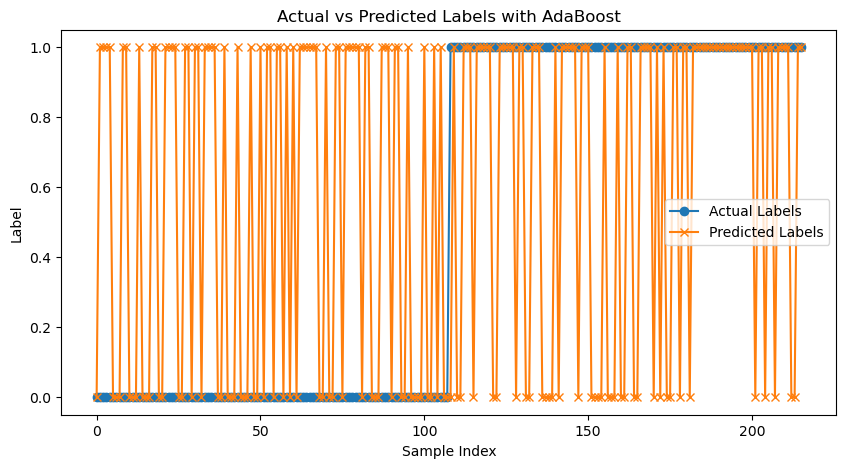

In [34]:
# Visualization of actual vs. predicted labels
def plot_accuracy():
    plt.figure(figsize=(10, 5))
    plt.plot(test_labels, label='Actual Labels', marker='o')
    plt.plot(test_predictions, label='Predicted Labels', marker='x')
    plt.title('Actual vs Predicted Labels with AdaBoost')
    plt.xlabel('Sample Index')
    plt.ylabel('Label')
    plt.legend()
    plt.show()

plot_accuracy()

In [35]:
# Load models for classification of new images
cnn_model = load_model('cnn_feature_extractor_optimized.h5')
ada_classifier = joblib.load('ada_classifier_optimized.pkl')

In [36]:
# Classify a new image
def classify_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    features = cnn_model.predict(img_array)
    features = features.reshape(1, -1)

    prediction = ada_classifier.predict(features)
    class_labels = {0: 'Male', 1: 'Female'}
    result = class_labels[prediction[0]]
    return result

In [37]:
# Test with a new image
img_path = r'C:/Users/DELL/Downloads/New_folder/SEC_Five/dataset/test/male/063848.jpg'
result = classify_image(img_path)
print(f"The image is classified as: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
The image is classified as: Male
